# Project 1

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import requests
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility
np.random.seed(3)

---

In this activity, We will use the Alpaca API to grab historical data for the stocks

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
fm_api_key=os.getenv("FM_API_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [84]:
# check to make sure matplotlib import is not redundant
import hvplot.pandas
import plotly.express as px
import matplotlib

%matplotlib inline

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [85]:
import panel as pn
from panel.interact import interact
from panel import widgets

# Data Collection

In this step, we will use the Alpaca api to fetch closing prices for the stocks. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["RY","WMT","AMZN","SPY"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes.
start_date = pd.Timestamp('2008-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-06-30', tz='America/New_York').isoformat()

# Get historical data for RY, ENB, AMZN and SPY
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data

df.tail()

,AMZN,RY,SPY,WMT
,close,close,close,close
2020-06-24 00:00:00-04:00,2733.49,67.28,304.12,120.35
2020-06-25 00:00:00-04:00,2756.16,68.30,307.31,119.63
2020-06-26 00:00:00-04:00,2692.87,66.70,300.01,118.31
2020-06-29 00:00:00-04:00,2681.52,67.45,304.43,119.09
2020-06-30 00:00:00-04:00,2756.09,67.80,308.57,119.66


# Data Cleanup

In this step, We will cleanup the dataframe if necessary 

In [6]:
# Dataframe describe to identify any anomaly

df.describe()

,AMZN,RY,SPY,WMT
,close,close,close,close
count,3146.000000,3146.000000,3146.000000,3146.000000
mean,639.924168,60.989259,186.261770,73.120366
std,646.925813,12.695632,66.400256,19.572283
min,35.040000,20.620000,68.070000,45.640000
25%,177.509000,52.575000,129.322500,55.512500
50%,321.936250,60.750000,186.320000,71.840000
75%,948.820000,71.730000,239.410000,80.946250
max,2764.420000,86.750000,338.337900,132.280000


In [7]:
# Determine whether there are any null values 

df.isna().sum()

AMZN  close    0
RY    close    0
SPY   close    0
WMT   close    0
dtype: int64

In [8]:
# Slicing the dataframe till 2019-12-31
# This dataframe will be used for monte-carlo simulation for the next 6 month 

data_monte_carlo_df = df.loc["2008-01-02 00:00:00-05:00":"2019-12-31 00:00:00-05:00"]

data_monte_carlo_df.tail()

,AMZN,RY,SPY,WMT
,close,close,close,close
2019-12-24 00:00:00-05:00,1789.63,78.63,321.26,119.52
2019-12-26 00:00:00-05:00,1869.02,78.65,322.91,119.55
2019-12-27 00:00:00-05:00,1869.26,79.08,322.86,119.57
2019-12-30 00:00:00-05:00,1847.18,79.01,321.10,119.42
2019-12-31 00:00:00-05:00,1847.64,79.20,321.92,118.79


In [9]:
# PLot the close prices for all the stocks 


In [10]:
df['AMZN']['close'][-1]

2756.09

In [27]:
# Bailey: I wasn't sure of the point of this cell
excerpt = df.loc['2011-06-01 00:00:00-04:00':"2020-06-30 00:00:00-04:00"]
excerpt.head()

,AMZN,RY,SPY,WMT
,close,close,close,close
2011-06-01 00:00:00-04:00,192.31,56.30,131.86,54.32
2011-06-02 00:00:00-04:00,193.62,56.52,131.70,53.53
2011-06-03 00:00:00-04:00,188.27,56.45,130.43,53.68
2011-06-06 00:00:00-04:00,185.70,55.48,129.05,53.77
2011-06-07 00:00:00-04:00,187.47,55.72,128.94,53.81


---

## Monte Carlo Simulation

In this step, we will run Monte Carlo Simulations for the stocks. 

Complete the following steps:

1. Calculate the daily returns of all the stocks.

2. Calculate volatility for all the stocks.

3. Find the last day's closing price for both the stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `500` iterations and generate `6` months closing prices


In [28]:
# Calculate the daily roi for the stocks
daily_returns = (
    data_monte_carlo_df.pct_change()
    .dropna()
)

# Display sample data
daily_returns.head()

,AMZN,RY,SPY,WMT
,close,close,close,close
2008-01-03 00:00:00-05:00,-0.010706,-0.006134,-0.000623,-0.010874
2008-01-04 00:00:00-05:00,-0.067661,-0.019311,-0.024436,-0.016167
2008-01-07 00:00:00-05:00,0.001127,-0.007714,0.003761,0.020596
2008-01-08 00:00:00-05:00,-0.010356,-0.004092,-0.018733,-0.014384
2008-01-09 00:00:00-05:00,-0.032188,0.004108,0.014192,0.022217


In [29]:
# Compute daily volatility for avg return 

avg_daily_return_ry = daily_returns.mean()["RY"]["close"]
print (f"Avg daily return of RY : {avg_daily_return_ry}")

avg_daily_return_amzn = daily_returns.mean()["AMZN"]["close"]
print (f"Avg daily return of AMZN : {avg_daily_return_amzn}")

avg_daily_return_wmt = daily_returns.mean()["WMT"]["close"]
print (f"Avg daily return of WMT : {avg_daily_return_wmt}")

avg_daily_return_spy = daily_returns.mean()["SPY"]["close"]
print (f"Avg daily return of SPY : {avg_daily_return_spy}")

Avg daily return of RY : 0.00028678435658930485
Avg daily return of AMZN : 0.001249899613761706
Avg daily return of WMT : 0.00038324183190931854
Avg daily return of SPY : 0.0003389606715403635


In [30]:
# Compute daily volatility for all the stocks

std_dev_ry = daily_returns.std()["RY"]["close"]
print (f"Daily Std deviation of RY : {std_dev_ry}")

std_dev_amzn = daily_returns.std()["AMZN"]["close"]
print (f"Daily Std deviation of AMZN : {std_dev_amzn}")

std_dev_wmt = daily_returns.std()["WMT"]["close"]
print (f"Daily Std deviation of WMT : {std_dev_wmt}")

std_dev_spy = daily_returns.std()["SPY"]["close"]
print (f"Daily Std deviation of SPY : {std_dev_spy}")

Daily Std deviation of RY : 0.016633511262165546
Daily Std deviation of AMZN : 0.023421956407704985
Daily Std deviation of WMT : 0.012295866790352387
Daily Std deviation of SPY : 0.012143530879416761


In [31]:
# Save the last day's closing price
last_price_ry = data_monte_carlo_df["RY"]["close"][-1]
print (f"RY price as of 2019-12-31 : {last_price_ry}")

last_price_amzn = data_monte_carlo_df["AMZN"]["close"][-1]
print (f"AMZN price as of 2019-12-31 : {last_price_amzn}")

last_price_wmt = data_monte_carlo_df["WMT"]["close"][-1]
print (f"WMT price as of 2019-12-31 : {last_price_wmt}")

last_price_spy = data_monte_carlo_df["SPY"]["close"][-1]
print (f"SPY price as of 2019-12-31 : {last_price_spy}")

RY price as of 2019-12-31 : 79.2
AMZN price as of 2019-12-31 : 1847.64
WMT price as of 2019-12-31 : 118.79
SPY price as of 2019-12-31 : 321.92


In [35]:
# Run the Monte Carlo Simulation
# Run the simulation of projecting stock prices for the next 6 months

def monte_carlo_sim(stock_last_price,stock_avg_return,stock_std_dev):
    
    # Setup the Monte Carlo Parameters
    number_simulations = 500
    number_records = 126
    monte_carlo = pd.DataFrame()
    simulated_price_df = pd.DataFrame()

    for n in range(number_simulations):

        # Initialize the simulated prices list with the last closing price stock
        simulated_prices = [stock_last_price]
    
        # Simulate the returns for 126 days
        for i in range(number_records):
        
            # Calculate the simulated price using the last price within the list
            simulated_price = simulated_prices[-1] * (1 + np.random.normal(stock_avg_return, stock_std_dev))
        
            # Append the simulated price to the list
            simulated_prices.append(simulated_price)
    
        # Append a simulated prices of each simulation to DataFrame
        simulated_price_df["Prices"] = pd.Series(simulated_prices)
    
        # Calculate the daily returns of simulated prices
        simulated_daily_returns = simulated_price_df.pct_change()
    
        # Set the portfolio weights (40% AGG; 60% SPY)
        weights = [1]

        # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
        portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
        # Calculate the normalized, cumulative return series
        monte_carlo[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
                
    return monte_carlo


In [36]:
# Check that the simulation ran successfully
ry_monte_carlo = monte_carlo_sim(last_price_ry, avg_daily_return_ry, std_dev_ry)

ry_monte_carlo.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
122,0.879341,1.511247,1.466009,1.006952,0.751691,0.997854,0.671064,0.946665,1.191030,1.108749,...,0.781850,0.972353,0.875664,1.069377,0.851858,1.198330,1.165620,1.080158,0.815546,1.168809
123,0.871554,1.472605,1.508353,1.014011,0.740102,0.999774,0.683596,0.962402,1.206518,1.130963,...,0.800223,0.969346,0.864830,1.072300,0.874781,1.210051,1.157045,1.066826,0.813785,1.174073
124,0.869066,1.503308,1.493586,1.038933,0.742008,0.991309,0.699904,0.969604,1.218966,1.107500,...,0.795816,0.998059,0.858321,1.087925,0.869323,1.196299,1.122205,1.091709,0.826956,1.177735
125,0.867241,1.491091,1.463937,1.038625,0.752911,0.986845,0.708980,0.984229,1.203947,1.128026,...,0.812964,1.019836,0.870859,1.082504,0.860032,1.206982,1.151945,1.090877,0.835863,1.176552
126,0.851119,1.477784,1.451940,1.026605,0.743303,0.979411,0.727046,0.984660,1.230370,1.123525,...,0.826427,0.994811,0.869572,1.061745,0.873789,1.195101,1.142777,1.120119,0.840025,1.178736


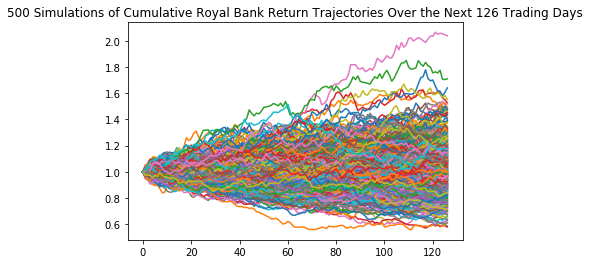

In [43]:
# Visualize the Simulation
# Bailey: manually changed {n+1} to 500 Simulations
plot_title = f"500 Simulations of Cumulative Royal Bank Return Trajectories Over the Next 126 Trading Days"
ry_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.734027
0.95    1.346108
Name: 126, dtype: float64


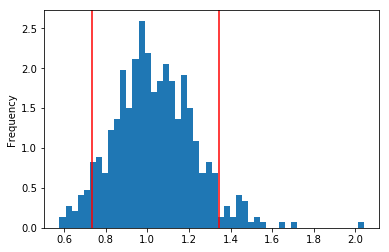

In [44]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ry_end_cum_retun = ry_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
ry_confi_inte = ry_end_cum_retun.quantile(q=[0.05, 0.95])
print (ry_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
ry_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(ry_confi_inte.iloc[0], color="r")
plt.axvline(ry_confi_inte.iloc[1], color="r")

In [45]:
# Check that the simulation ran successfully
amzn_monte_carlo = monte_carlo_sim(last_price_amzn, avg_daily_return_amzn, std_dev_amzn)

amzn_monte_carlo.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
122,1.229692,1.241234,1.047966,1.116732,1.217641,1.088694,1.264374,1.149129,1.147163,1.014817,...,0.937314,1.292134,0.953266,1.227923,1.337668,1.341458,1.458593,1.770805,1.211139,0.972038
123,1.253883,1.188277,1.044254,1.105849,1.230413,1.086677,1.262989,1.170623,1.119700,1.031066,...,0.974305,1.319757,0.939709,1.220749,1.290186,1.319251,1.447806,1.815974,1.228550,0.984816
124,1.229786,1.168192,1.041975,1.147026,1.250767,1.067424,1.228376,1.242403,1.101691,1.007268,...,0.966932,1.345476,0.969526,1.241149,1.270540,1.354922,1.462316,1.853831,1.203087,0.943622
125,1.189782,1.135393,1.029893,1.124957,1.189789,1.095994,1.270246,1.241799,1.144838,1.005901,...,0.929415,1.329525,0.935378,1.216590,1.303676,1.317419,1.479342,1.879898,1.219772,0.945238
126,1.182553,1.112196,1.026176,1.115594,1.164102,1.090776,1.225666,1.230487,1.163339,0.999591,...,0.942253,1.358018,0.924042,1.246354,1.304703,1.297105,1.528555,1.890125,1.186288,0.943689


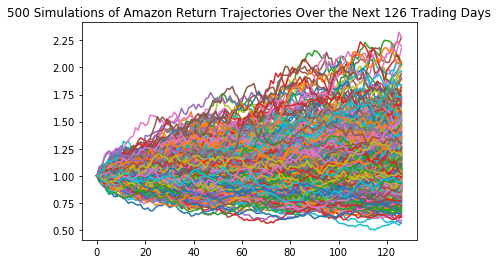

In [47]:
# Visualize the Simulation
# Bailey: manually changed {n+1} to 500 Simulations
plot_title = f"500 Simulations of Amazon Return Trajectories Over the Next 126 Trading Days"
amzn_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.729022
0.95    1.720115
Name: 126, dtype: float64


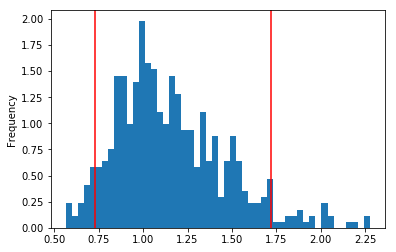

In [48]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
amzn_end_cum_retun = amzn_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
amzn_confi_inte = amzn_end_cum_retun.quantile(q=[0.05, 0.95])
print (amzn_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
amzn_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(amzn_confi_inte.iloc[0], color="r")
plt.axvline(amzn_confi_inte.iloc[1], color="r")

---

In [49]:
# Check that the simulation ran successfully
wmt_monte_carlo = monte_carlo_sim(last_price_wmt, avg_daily_return_wmt, std_dev_wmt)

wmt_monte_carlo.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
122,0.885248,1.003254,1.063683,1.025446,1.212527,0.935599,0.941607,0.989379,0.934791,1.255256,...,1.138350,0.912337,1.111225,1.254885,0.927858,0.957537,1.015125,1.140283,1.179554,1.005438
123,0.862389,0.994320,1.060624,1.021665,1.189594,0.945021,0.933999,0.971818,0.909189,1.249880,...,1.170753,0.908605,1.087606,1.227933,0.911667,0.979275,1.011265,1.142828,1.174977,0.986666
124,0.855033,0.993528,1.101184,1.010338,1.204375,0.946594,0.935142,0.968639,0.916949,1.266350,...,1.177587,0.926030,1.088518,1.210128,0.903090,0.987257,1.011208,1.158554,1.195383,0.984520
125,0.845005,0.985708,1.116689,1.005726,1.223285,0.967904,0.924630,0.982241,0.924863,1.251472,...,1.189552,0.917227,1.084278,1.218520,0.899079,0.990115,0.996201,1.186993,1.214900,0.996127
126,0.852923,0.972236,1.121320,1.002170,1.226204,0.953851,0.915168,0.987638,0.932498,1.241444,...,1.217425,0.935988,1.085215,1.219499,0.911544,0.969841,0.993633,1.199607,1.191438,0.994038


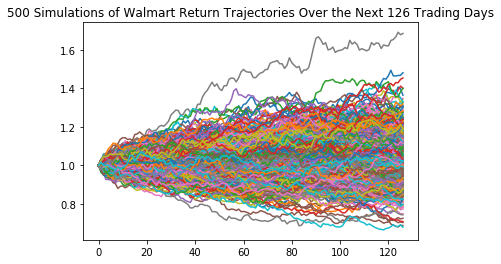

In [51]:
# Bailey: manually changed {n+1} to 500 Simulations
plot_title = f"500 Simulations of Walmart Return Trajectories Over the Next 126 Trading Days"
wmt_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.843330
0.95    1.251881
Name: 126, dtype: float64


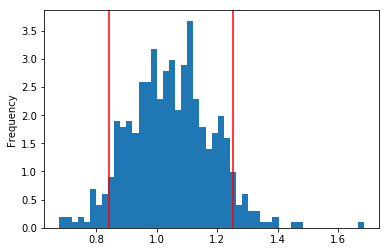

In [52]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
wmt_end_cum_retun = wmt_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
wmt_confi_inte = wmt_end_cum_retun.quantile(q=[0.05, 0.95])
print (wmt_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
wmt_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(wmt_confi_inte.iloc[0], color="r")
plt.axvline(wmt_confi_inte.iloc[1], color="r")

-------

# Bailey's Section
## Fundamental Analysis

Bailey will create a dashboard containing data from each company's financial statements. The dashboard will contain:
* Balance Sheet Bar Chart (Total Assests, Total Liabilities, Total Equity)
* Income Statement Bar Chart (Net Income, Operating, Total Revenue)
* Cash Flow Statement Bar Chart (Operations, Investing, Financing)

The dashboard will also contain the following financial ratios:
* P/E Ratio
* Earnings per Share
* Return on Equity

In [883]:
#     'AMZN': ['2019-12-31', '2009-12-31'],
#     'WMT': ['2020-01-31', '2010-01-31'],
#     'RY': ['2018-10-31', '2009-10-31']}
    
#     'RY': ['2002-01-31', '2020-01-31'],
#     'AMZN': ['2002-01-31', '2020-01-31'],
#     'WMT': ['2002-01-31', '2020-01-31']}

In [884]:
stock_list = ['RY','WMT','AMZN']

In [885]:
def get_fin_statement(stock_ticker):
    balance_sheet_url = f"https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{stock_ticker}?apikey={fm_api_key}"
    balance_sheet_req = requests.get(url = balance_sheet_url)
    balance_sheet_data = balance_sheet_req.json()

    income_url = f"https://financialmodelingprep.com/api/v3/financials/income-statement/{stock_ticker}?apikey={fm_api_key}"
    income_state_req = requests.get(url = income_url)
    income_state_data = income_state_req.json()

    cash_flow_url = f"https://financialmodelingprep.com/api/v3/financials/cash-flow-statement/{stock_ticker}?apikey={fm_api_key}"
    cash_flow_req = requests.get(url = cash_flow_url)
    cash_flow_data = cash_flow_req.json()
    
    ratios_url = f'https://financialmodelingprep.com/api/v3/ratios/{stock_ticker}?apikey={fm_api_key}'
    ratios_req = requests.get(url = ratios_url)
    ratios_data = ratios_req.json() 
      
    return balance_sheet_data, income_state_data, cash_flow_data, ratios_data

In [886]:
ry_balance_sheet_data, ry_income_state_data, ry_cash_flow_data,ry_ratio = get_fin_statement("RY")
amzn_balance_sheet_data, amzn_income_state_data, amzn_cash_flow_data, amzn_ratio = get_fin_statement("AMZN")
wmt_balance_sheet_data, wmt_income_state_data, wmt_cash_flow_data, wmt_ratio = get_fin_statement("WMT")

In [887]:
def add_fiscal(df, df_type, ticker):
    '''
    Add Fiscal Years to all financial statement and financial ratio dataframes.
    
    '''
    
    df = df.sort_values(by='date', ascending=True)
    
    # if the df is from the financial statements. Use these Fiscal Dates
    if df_type == 'statement':
        
        if ticker == 'WMT' or ticker == 'AMZN':
            df['Fiscal Year'] = [2009+i for i in range(11)]
            df = df.set_index('Fiscal Year')
            return df

        elif ticker == 'RY':
            df['Fiscal Year'] = [2009+i for i in range(10)]
            df = df.set_index('Fiscal Year')
            return df
    
    # if the df is from the ratios. Use these Fiscal Dates.
    elif df_type == 'ratio':
        if ticker == 'WMT' or ticker == 'AMZN':
            df['Fiscal Year'] = [2001+i for i in range(19)]
            df = df.set_index('Fiscal Year')
            return df
            
        if ticker == 'RY':
            df['Fiscal Year'] = [2009+i for i in range(10)]
            df = df.set_index('Fiscal Year')
            return df
    
    else:
        return

In [888]:
def clean_ratios(data,ticker):
    '''
    Cleans the json file from the API and returns financial ratios.
    '''
    # ratios to be pulled from json
    ratios = ['returnOnEquity','dividendPayoutRatio','priceEarningsRatio']

    ratio_dict = {}
    df = pd.DataFrame()
    
    # pulls dates and ratios and adds them to a df
    for annual_report in data:
        ratio_dict['date'] = annual_report['date']
        
        for ratio in ratios:  
            ratio_dict[ratio] = annual_report[ratio]
            
        df = df.append(ratio_dict,True)
    
    df = df.rename(columns = {'returnOnEquity':'Return on Equity',
                    'dividendPayoutRatio':'Dividend Payout Ratio',
                    'priceEarningsRatio':'Price Earnings Ratio'})
    
    df = df.sort_values(by='date', ascending=True)
    
    df = add_fiscal(df,'ratio',ticker)
    
    df = df.drop('date',1)
    
    df = df.astype('float')
        
    return df

In [889]:
def clean_fs_data(data,statement_type,ticker):
    '''
    Cleans the json file from the API and returns one of the three financial statements.
    
    statement_type should be 'cf' 'is' or 'bs' for financial statements. 
    '''
    
    # components to be pulled for each statement
    cash_flow = ['Operating Cash Flow', 'Investing Cash flow', 'Financing Cash Flow']
    income_st = ['Net Income', 'Operating Income','Revenue']
    balance_sh = ['Total assets','Total liabilities','Total shareholders equity']
    
    # branching to determine the type of financial statement that was given.
    if statement_type == 'cf':
        statement = cash_flow
        
    elif statement_type == 'is':
        statement = income_st
        
    elif statement_type == 'bs':
        statement = balance_sh
        
    else:
        return 'invalid entry'

    # pulling data from json.
    df = pd.DataFrame()
    data_dict = {}

    for financial_statement in data["financials"]:
        data_dict['date'] = financial_statement['date']
        
        for item in statement:
            data_dict[item] = financial_statement[item]

        df = df.append(data_dict, True)
    
    df = df.sort_values(by='date', ascending=True)
    
    df = add_fiscal(df,'statement',ticker)
    
    df = df.drop('date',1)
    
    df = df.astype('float')

    return df

In [890]:
# RY Data clean
RY_CF = clean_fs_data(ry_cash_flow_data,'cf','RY')
RY_BS = clean_fs_data(ry_balance_sheet_data,'bs','RY')
RY_IS = clean_fs_data(ry_income_state_data,'is','RY')
RY_Rat = clean_ratios(ry_ratio,'RY')

# AMZN Data clean
AMZN_CF = clean_fs_data(amzn_cash_flow_data,'cf','AMZN')
AMZN_BS = clean_fs_data(amzn_balance_sheet_data,'bs','AMZN')
AMZN_IS = clean_fs_data(amzn_income_state_data, 'is','AMZN')
AMZN_Rat = clean_ratios(amzn_ratio,'AMZN')

# WMT Data clean
WMT_CF = clean_fs_data(wmt_cash_flow_data,'cf','WMT')
WMT_BS = clean_fs_data(wmt_balance_sheet_data,'bs','WMT')
WMT_IS = clean_fs_data(wmt_income_state_data,'is','WMT')
WMT_Rat = clean_ratios(wmt_ratio,'WMT')

In [891]:

## I need to drop fiscal years that are not relevant

In [892]:
def ratio_graph(df):
    df = df.reset_index()
    
    df = pd.melt(df,id_vars=['Fiscal Year'], var_name='Ratio', value_name='values')
    
    return df.hvplot(x='Fiscal Year',
                      y='values',
                      xticks=list(set(df['Fiscal Year'])),
                      groupby='Ratio',
                     title= f'Financial Ratios')

def statement_graphs(df,title):
    fig = px.bar(df,
                 x=df.index,
                 y=df.columns,
                 barmode='group',
                 title=f'{title}'
                )
    
    return fig

In [893]:
# creation of panels
RY_panel = pn.Column(pn.Row(ratio_graph(RY_Rat)),
                     pn.Row(statement_graphs(RY_BS,'Balance Sheet Statement'),
                            statement_graphs(RY_IS,'Income Statement'),
                            statement_graphs(RY_CF,'Cash Flow Statement'))
                    )

AMZN_panel = pn.Column(pn.Row(ratio_graph(AMZN_Rat)),
                       pn.Row(statement_graphs(AMZN_BS,'Balance Sheet Statement'),
                              statement_graphs(AMZN_IS,'Income Statement'),
                              statement_graphs(AMZN_CF,'Cash Flow Statement'))
                      )

WMT_panel = pn.Column(pn.Row(ratio_graph(WMT_Rat)),
                      pn.Row(statement_graphs(WMT_BS,'Balance Sheet Statement'),
                             statement_graphs(WMT_IS,'Income Statement'),
                             statement_graphs(WMT_CF,'Cash Flow Statement'))
                     )


In [894]:
dashboard = pn.Column('# Fundamental Analysis of RBC, Amazon, and Walmart',
                      pn.Tabs(
                          ("RBC", RY_panel),
                          ("Amazon",AMZN_panel),
                          ('Walmart',WMT_panel),
                      )
                     )

In [895]:
dashboard.show()

Launching server at http://localhost:51681


## To do:
* trim fiscal years that are not in all data sets
* make note about fiscal year assumptions
* Add analysis
* read more about [formatting dashboards](https://panel.holoviz.org/user_guide/Components.html)
* clarify comments

# Support and Resistance Index Graphs
Also Bailey.